# Time series classification

Calculation of the MFCC using CMSIS Digital Signal Processing Library and relative Python Wrapper.

[CMSIS DSP library](https://github.com/STMicroelectronics/STM32CubeU5/tree/main/Drivers/CMSIS/DSP) is made by ARM and it is optimized for its microcontroller cores, including of course STM32 series by STMicroelectronics. The [Python wrapper](https://developer.arm.com/documentation/102463/latest/) for the CMSIS DSP functions allows experimenting with them in a Python notebook. It ensures that processing results will be equivalent when porting an algorithm to a microcontroller and using C.

In [1]:
import sys
sys.path.insert(1, 'vespucci')
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from pre_processing import *
from ml_support import *


In [2]:
pre_processing_data = pre_processing_init()
CLASSES = ["Off", "On", "Cutting"]

In [3]:
import HSD_utils.logger as logger
from HSD.HSDatalog import HSDatalog

In [4]:
sensor = 'ISM330DHCX'
sensor_type = 'ACC'
folder_path='datasets'+'/'+'cuscinetto_2g'

hsd = HSDatalog(folder_path)
df = hsd.get_dataframe(sensor,sensor_type,sample_start=0,sample_end=-1,labeled = False)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Clusters

In [5]:
X = pre_processing_process(df, pre_processing_data)

In [6]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=3,affinity = 'euclidean',linkage = 'ward')
model = model.fit(X)


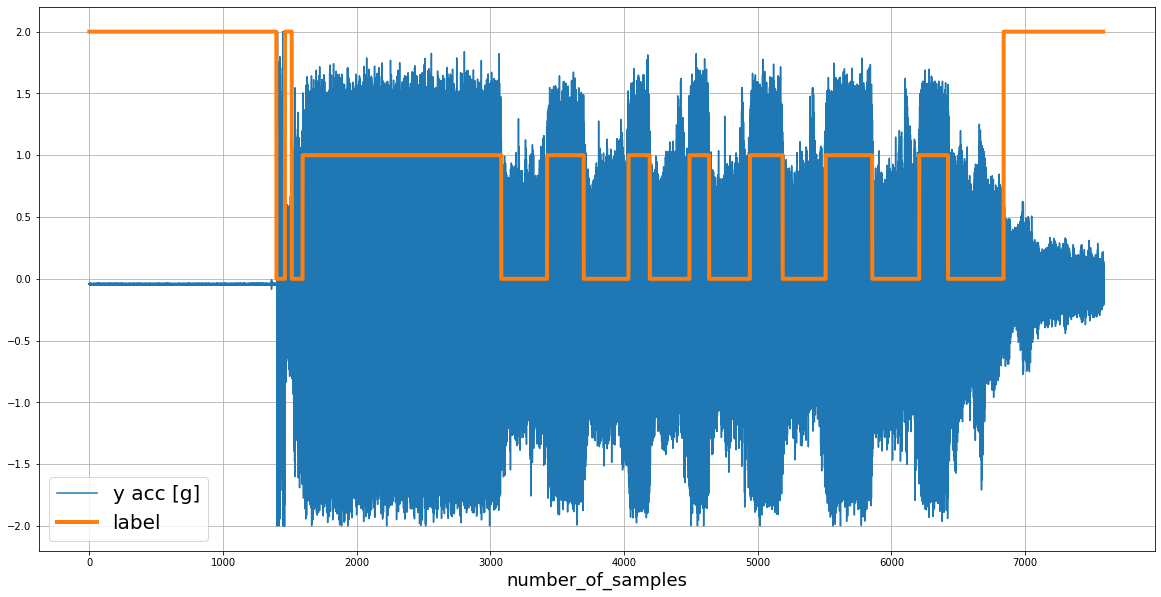

In [7]:
plt.figure(figsize=(20,10))
plt.plot(np.array(df.index)/56,df['A_y [g]'])
plt.plot(model.labels_, linewidth = 4)
plt.xlabel("number_of_samples",fontsize=18)
plt.legend(["y acc [g]","label"],prop={'size': 20})
plt.grid()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Linear Discriminant Analysis LDA

In [8]:
def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)


def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip



In [9]:
lda = LDA(n_components=2)
y = model.labels_
x_lda = lda.fit_transform(X, y)

x_lda_On = x_lda[y==1]
x_lda_Off = x_lda[y==2]
x_lda_Cutting = x_lda[y==0]

x_lda_Off_avg = np.mean(x_lda_Off,axis = 0)
x_lda_On_avg = np.mean(x_lda_On,axis = 0)
x_lda_Cutting_avg = np.mean(x_lda_Cutting,axis = 0)

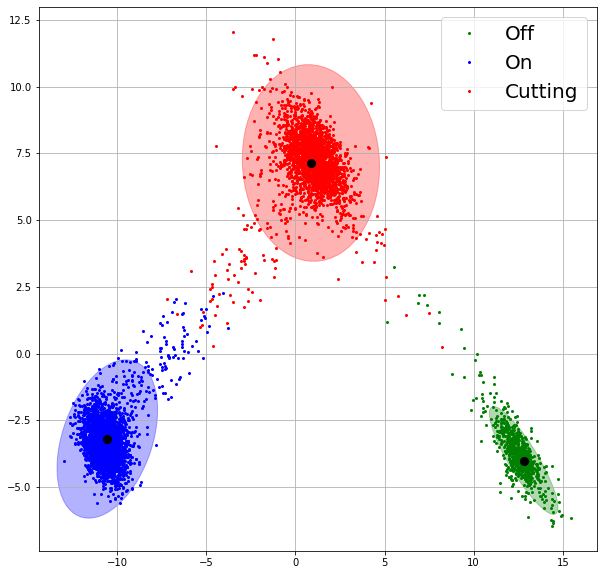

In [10]:
fig, ax  = plt.subplots(figsize=(10,10))

ax.plot(x_lda_Off[:,0],x_lda_Off[:,1],'go',markersize = 2)
ax.plot(x_lda_On[:,0],x_lda_On[:,1],'bo',markersize = 2)
ax.plot(x_lda_Cutting[:,0],x_lda_Cutting[:,1],'ro',markersize = 2)


ax.plot(x_lda_Off_avg[0],x_lda_Off_avg[1],'ko',markersize=8)
ax.plot(x_lda_Cutting_avg[0],x_lda_Cutting_avg[1],'ko',markersize=8)
ax.plot(x_lda_On_avg[0],x_lda_On_avg[1],'ko',markersize=8)

plot_point_cov(x_lda_Off, nstd=3, alpha=0.3, color='green')
plot_point_cov(x_lda_On, nstd=3, alpha=0.3, color='blue')
plot_point_cov(x_lda_Cutting, nstd=3, alpha=0.3, color='red')

ax.legend(['Off','On','Cutting'],prop={'size': 20})
ax.grid()


<br>
<br>
<br>
<br>

## MFCC Calculation process

Based on the previously choosen accelerometer axis the accelerometric signal must be stored in a numpy array in order to calculate the MFCC

Calculation sequence:
- Hanning window
- fft
- Mel spectrum 
- 20*log(Mel Spectrum)
- DCT

<br>

User input parameters: 
- n_samples: 512, 1024, 2048, ...
- shift_samples: for data augmentation purpose

In [11]:
X_Off = X[y==2]
X_On = X[y==1]
X_Cutting = X[y==0]

In [17]:
X_on_avg = np.mean(X_On,axis = 0)
X_on_high = np.percentile(X_On,99,axis = 0)
X_on_low = np.percentile(X_On,1,axis = 0)

X_cutting_avg = np.mean(X_Cutting,axis = 0)
X_cutting_high = np.percentile(X_Cutting,99,axis = 0)
X_cutting_low = np.percentile(X_Cutting,1,axis = 0)

freq = np.arange(0,pre_processing_data.ism330dhcx_odr/2,(pre_processing_data.ism330dhcx_odr/2)/X_on_avg.shape[0])[0:X_on_avg.shape[0]]

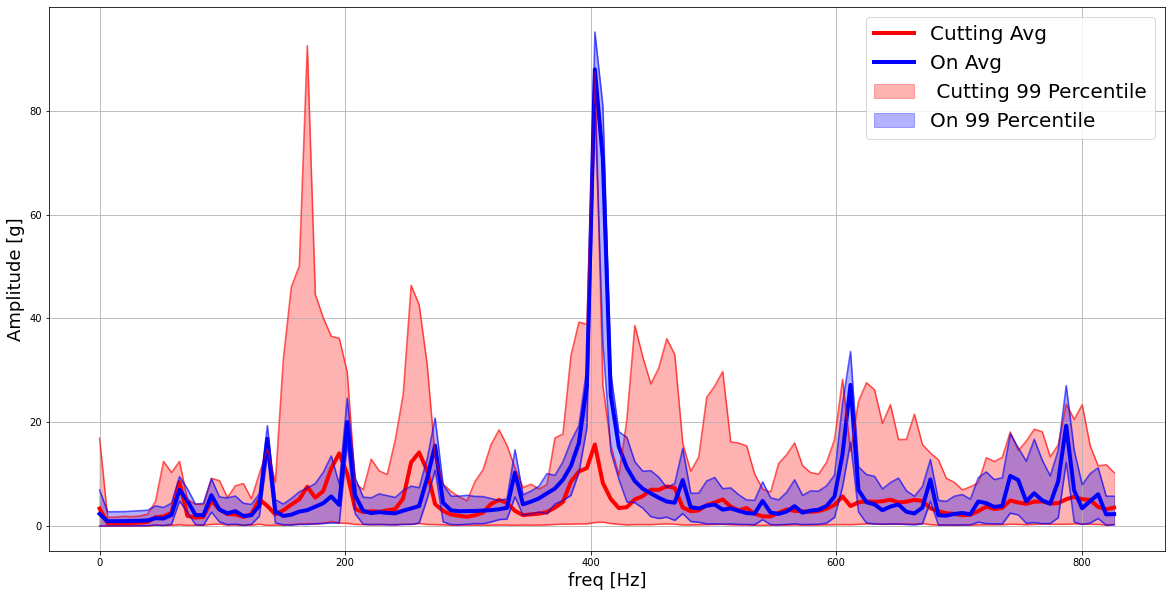

In [26]:
plt.figure(figsize =(20,10) )
plt.plot(freq,X_cutting_avg,'r',linewidth = 4)
plt.plot(freq,X_on_avg,'b',linewidth = 4)

plt.fill_between(freq,X_cutting_low, X_cutting_high, color='r', alpha=0.3)
plt.fill_between(freq,X_on_low, X_on_high, color='b', alpha=0.3)

plt.plot(freq,X_cutting_low, 'r', alpha=0.6)
plt.plot(freq,X_cutting_high, 'r', alpha=0.6)

plt.plot(freq,X_on_low, 'b', alpha=0.6)
plt.plot(freq,X_on_high, 'b', alpha=0.6)


plt.legend(["Cutting Avg","On Avg"," Cutting 99 Percentile","On 99 Percentile"],prop={'size': 20})
plt.xlabel("freq [Hz]",fontsize=18)
plt.ylabel("Amplitude [g]",fontsize=18)
plt.grid()


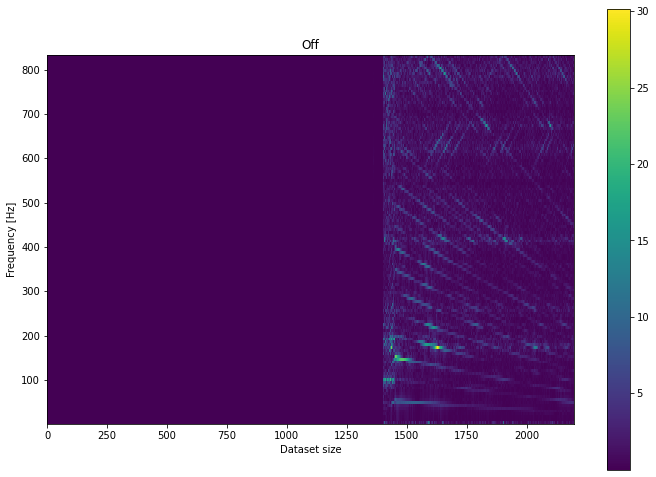

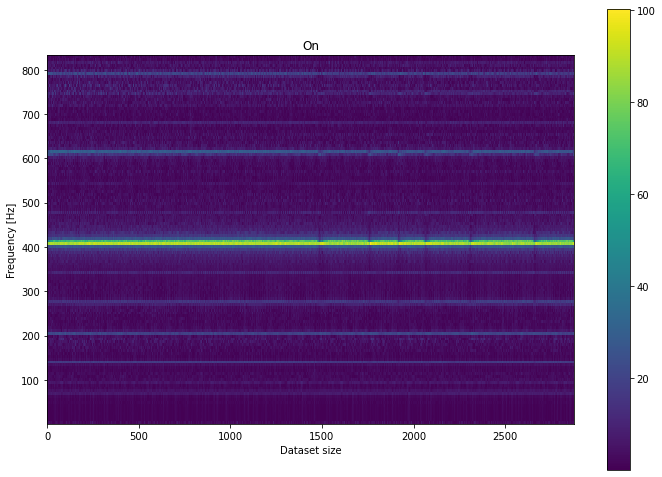

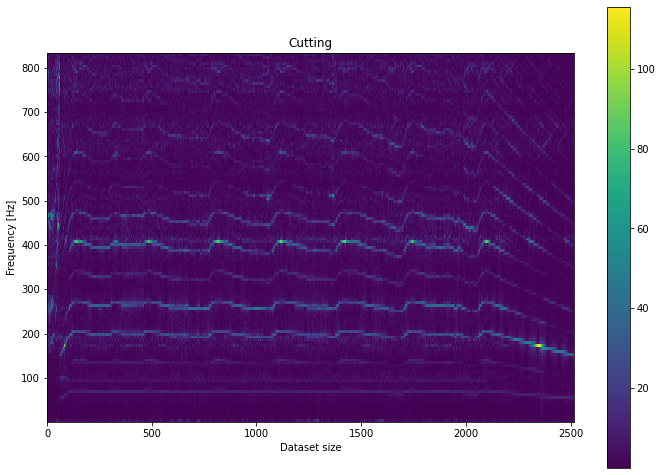

In [19]:
show_spectrogram(X_Off.T,0.7,[0, X_Off.shape[0], pre_processing_data.ism330dhcx_odr/2,1], title=CLASSES[0], x_label ="Dataset size", y_label = "Frequency [Hz]")
show_spectrogram(X_On.T,0.7,[0, X_On.shape[0], pre_processing_data.ism330dhcx_odr/2 ,1], title=CLASSES[1], x_label ="Dataset size", y_label = "Frequency [Hz]")
show_spectrogram(X_Cutting.T,0.7,[0, X_Cutting.shape[0], pre_processing_data.ism330dhcx_odr/2 ,1], title=CLASSES[2], x_label ="Dataset size", y_label = "Frequency [Hz]")


In [ ]:
model.summary()

In [ ]:
# Binarization of categorical labels
# From a single vector containing the class number from 0 to 4 
# To a matrix of dimension len(y) and 4 columns cotaining 0 or 1 based for each label
lb = preprocessing.LabelBinarizer()
lb.fit(y)
y=lb.transform(y)

# Data randomization
idx = np.random.permutation(len(X))
X = X[idx]
y=y[idx]

# train/test split
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=1)
trainX, validationX, trainY, validationY = train_test_split(trainX, trainY, test_size=0.25, random_state=1)

'''
model = tf.keras.models.Sequential([ 
    tf.keras.layers.InputLayer(input_shape = (trainX.shape[1])),
    tf.keras.layers.Dense( 20 , activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense( 20 , activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense( len(CLASSES), activation = 'softmax')
    ])
'''


model = tf.keras.models.Sequential([ 
    tf.keras.layers.InputLayer(input_shape = (trainX.shape[1])),
    tf.keras.layers.Dense( 50 , activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense( 50 , activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense( len(CLASSES), activation = 'softmax')
    ])


'''
model = tf.keras.models.Sequential([ 
    tf.keras.layers.InputLayer(input_shape = (trainX.shape[1])),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense( len(CLASSES), activation = 'softmax')
    ])

'''
# the user can change the learning rate and the batch size
learningRate = 1e-4
batchSize = 128

_, score = evaluate_model(trainX, trainY ,
                                    validationX, validationY, 
                                    testX, testY, 
                                    model,
                                    learningRate = learningRate,
                                    batchSize = batchSize,
                                    verbosity = 1,
                                    ConfusionMatrix=True,
                                    learning_curves=True)


In [ ]:
save_model(model, 'Lab')

<br>
<br>
<br>
<br>
<br>
<br>
<br>


# Test

In [ ]:
def load_data_by_tag(sensor,folder_path, resampling_active = False , resampling_frequency = 6667, plot_active = False):
    
    # add switch case for each STWIN sensor
    if sensor == 'ISM330DHCX':
        sensor_type = 'ACC'
        available_res_freq = np.array([12.5 , 26 , 52 , 104, 208, 416, 833, 1666, 3332, 6667])

    # load data from folder using HSD API 
    hsd = HSDatalog(folder_path)
    df = hsd.get_dataframe(sensor,sensor_type,sample_start=0,sample_end=-1,labeled = True)

    # label list
    label_list = hsd.get_acquisition_label_classes()

    # signal downsampling 
    if resampling_active == True:
        if resampling_frequency not in available_res_freq:
            print('########  NEW SAMPLING FREQUENCY CHOSEN NOT AVAILABLE, NO RESAPLING HAS BEEN APPLIED  ########')
            print('')
        else:
            df = signal_resampling(df, resampling_frequency)

    # store data into different dataframes by tag name
    print('Dataframes loaded: ')
    for ii in range(len(label_list)):

        globals()['df_'+sensor_type+'_'+label_list[ii]] = df[df[label_list[ii]]==True]
            
        if plot_active == True:
            hsd.get_sensor_plot(sensor,sensor_type, label=label_list[ii])
        
        print('df_'+sensor_type+'_'+label_list[ii])

In [ ]:
load_data_by_tag(sensor = 'ISM330DHCX', folder_path='datasets'+'/'+'off_on_test', plot_active=False)


In [ ]:

np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})
np.array(df_ACC_On_test.iloc[0:512,2])

X_Test = pre_processing_process(df_ACC_On_test, pre_processing_data)
print(X_Test[0,5])

model_test = tf.keras.models.load_model('Saved_models/Lab')
print(model_test.predict(X_Test))